In [1]:
"""
This notebook contains a neural network built from scratch in Numpy.

Includes the following:
-Data standardization
-ReLU activation function
-Can use arbitrary number of layers and inputs/outputs
-Can define size of layers

Future enhancements will include
-mini-batch gradient descent
-regularization
-dropout
-numerical gradient (for gradient checking)
-momentum / adam optimizer
-early stopping
-test set

Some code inspired by CS231 Convolutional Neural Nets Stanford course
http://cs231n.github.io/neural-networks-case-study/
and Neural Networks and Deep Learning book
http://neuralnetworksanddeeplearning.com/chap1.html
"""

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.datasets.samples_generator import make_moons

N_DATA = 200
# sizes represents the size for each layer and are in the following 
# order [inputs, hidden1, hidden2, ..., hiddenlast, outputs]
# use sizes to specify number of layers, i.e. sizes [2, 50, 50, 2] has two hidden layers
SIZES = [2, 50, 50, 2]
N_EPOCHS = 500
LEARNING_RATE = 1.0


class NeuralNet(object):
    """Simple implementation of neural network."""
    
    def __init__(self, X, y, sizes, learning_rate):
        """Initialize parameters of network."""
        self.X = X
        self.y = y
        self.n_data = X.shape[0]
        self.n_layers = len(sizes)
        self.sizes = sizes
        # biases/weights are lists with each entry containing the
        # the biases/weights for a given layer
        self.biases = [np.zeros((1, n)) for n in sizes[1:]]
        self.weights = [np.random.randn(m, n) * np.sqrt(2.0/m)
                        for m, n in zip(sizes[:-1], sizes[1:])]
        self.lr = learning_rate

    def _backprop(self):
        """Backpropagation to train network."""
        # Forward Pass
        activations = [self.X]
        for i in range(self.n_layers-1):
            if i < self.n_layers - 2:
                # apply ReLU activation for hidden layers
                activations.append(relu(np.dot(
                    activations[i], self.weights[i]) + self.biases[i]))
            else:
                # apply softmax at final layer
                output = softmax(np.dot(
                    activations[-1], self.weights[i]) + self.biases[i])

        
        # get final layer output and compute cross entropy loss
        logit = -np.log(output[range(self.n_data), self.y])
        self.loss = np.sum(logit) / self.n_data

        # Backward Pass
        # gradient w.r.t. final error
        delta = output
        delta[range(self.n_data), self.y] -= 1
        delta /= self.n_data

        # compute gradients w.r.t. weights and biases
        d_weights, d_biases = [], []
        d_layer = delta
        for i in range(self.n_layers-1):
            if i > 0:
                d_layer = np.dot(d_layer, self.weights[-i].T)
                # need to zero out activations below zero b/c ReLU
                d_layer[activations[-i] <= 0] = 0
            d_weights.append(np.dot(activations[-i-1].T, d_layer))
            d_biases.append(np.sum(d_layer, axis=0, keepdims=True))           
        
        # update parameters
        for i in range(self.n_layers-1):
            self.weights[i] += -self.lr * d_weights[-i-1]
            self.biases[i] += -self.lr * d_biases[-i-1]
            
    def grad_descent(self):
        """Perform gradient descent updates.""" 
        for i in range(N_EPOCHS):
            # update parameters by running backpropagation
            self.params = self._backprop()
            if i % 50 == 0:
                print('iteration {0}: loss {1:.2f}'.format(i, self.loss))
            
    def predict(self, data):
        """Forward pass through the network to predict class for observation."""
        activations = [data]
        for i in range(self.n_layers-1):
            if i < self.n_layers - 2:
                # apply ReLU activation for hidden layers
                activations.append(relu(np.dot(
                    activations[i], self.weights[i]) + self.biases[i]))
            else:
                output = np.dot(activations[-1], self.weights[i]) + self.biases[i]
        # return argmax instead of softmax as we only care about top prediction
        return np.argmax(output, axis=1)


def softmax(z):
    """Softmax function. Subtract max to prevent overflow."""
    return np.exp(z - np.max(z)) / np.sum(np.exp(z - np.max(z)), axis=1, keepdims=True)
    

def relu(z):
    """ReLU activation function."""
    return np.maximum(0, z)


def data_normalize(X):
    """Normalize data to zero mean and divide by standard deviation."""
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    return X


def plot_decision_boundary(X, y, network):
    """Plot data points with decision boundaries."""
    h = 0.02
    # create grid of points for prediction
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # use trained network to make class prediction at each point
    Z = network.predict(grid)
    Z = Z.reshape(xx.shape)
    fig = plt.figure()
    # plot decision boundaries as defined by model
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    # plot data points
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='black', s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()

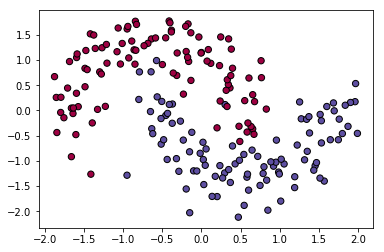

In [2]:
# Generate a dataset and plot it
X, y = make_moons(n_samples=N_DATA, noise=0.20)

# standardize data
X_std = data_normalize(X)

plt.scatter(X_std[:,0], X_std[:,1], c=y, edgecolors='black', s=40, cmap=plt.cm.Spectral)
plt.show()

In [3]:
# create neural net object
nn = NeuralNet(X_std, y, SIZES, LEARNING_RATE)
# run gradient descent
nn.grad_descent()

iteration 0: loss 1.04
iteration 50: loss 0.07
iteration 100: loss 0.05
iteration 150: loss 0.03
iteration 200: loss 0.03
iteration 250: loss 0.02
iteration 300: loss 0.02
iteration 350: loss 0.02
iteration 400: loss 0.02
iteration 450: loss 0.01


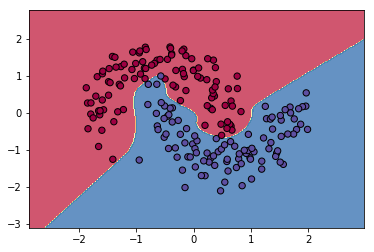

In [4]:
plot_decision_boundary(X_std, y, nn)